In [11]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 

In [3]:
pd.set_option('display.max_columns',100)

In [13]:
# importing of data
base_url = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/"
comp_url = base_url + "matches/{}/{}.json"
match_url = base_url + "events/{}.json"

def parse_data(competition_id, season_id):
    matches = requests.get(url=comp_url.format(competition_id, season_id)).json()
    match_ids = [m['match_id'] for m in matches]

    all_events = []
    for match_id in tqdm(match_ids):

        events = requests.get(url=match_url.format(match_id)).json()
        shots = [x for x in events if x['type']['name'] == "Shot"]
                
        for s in shots:
            attributes = {
                "x": s['location'][0],
                "y": s['location'][1],
                "head": 1 if s['shot']['body_part']['name'] == "Head" else 0,
                "phase": s['shot']['type']['name'],
                "outcome": 1 if s['shot']['outcome']['name'] == "Goal" else 0,
                "statsbomb_xg": s['shot']['statsbomb_xg']
            }
            all_events.append(attributes)
            
    return pd.DataFrame(all_events)

competition_id = 43
season_id = 3
df = parse_data(competition_id, season_id)

100%|█████████████████████████████████████████████| 64/64 [00:47<00:00,  1.35it/s]


In [14]:
# pre-analysis of the data
df

,x,y,head,phase,outcome,statsbomb_xg
0,97.0,32.0,0,Open Play,0,0.037902
1,108.0,51.0,0,Open Play,0,0.044519
2,109.0,55.0,0,Open Play,0,0.040015
3,102.0,23.0,0,Open Play,0,0.026998
4,114.0,48.0,1,Open Play,0,0.040895
...,...,...,...,...,...,...
1701,102.0,22.0,0,Open Play,0,0.048505
1702,95.0,30.0,0,Free Kick,0,0.081573
1703,116.0,30.0,0,Open Play,0,0.060032
1704,101.0,58.0,0,Open Play,0,0.016948


In [5]:
# cleaning of the data
shots = df[~df['phase'].isin(['Free Kick', 'Penalty'])]


In [24]:
# manipulate the data
def distance_to_goal(origin):
    dest = np.array([120., 40.])
    return np.sqrt(np.sum((origin - dest) ** 2))

def goal_angle(origin):
    p0 = np.array((120., 36.))  # Left Post
    p1 = np.array(origin, dtype=np.float)
    p2 = np.array((120., 44.))  # Right Post

    v0 = p0 - p1
    v1 = p2 - p1

    angle = np.abs(np.math.atan2(np.linalg.det([v0, v1]), np.dot(v0, v1)))
    
    return angle

shots['distance_to_goal'] = shots.apply(lambda row: distance_to_goal(row[['x', 'y']]), axis=1)
shots['goal_angle'] = shots.apply(lambda r: goal_angle(r[['x', 'y']]), axis=1)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 

In [25]:
# analyze the data
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

# choosing which columns for it to decide the important values
features = shots[['distance_to_goal', 'goal_angle', 'head']]
labels = shots['outcome']

fit = model.fit(features, labels)
predictions = model.predict_proba(features)[:, 1]

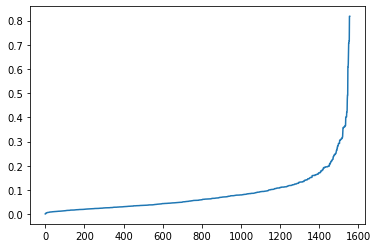

In [26]:
# output the data in some form or manner
plt.plot(sorted(predictions))
plt.show()